In [82]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras_tuner as kt

tf.config.threading.set_intra_op_parallelism_threads(64)
tf.config.threading.set_inter_op_parallelism_threads(64)

# Load the data
X = pd.read_csv('hawaii_predict.csv')
y = pd.read_csv('hawaii_response.csv')

# Replace missing values in y with NaN
y = y.replace("?", np.nan)  # If missing values are marked with "?" in the dataset
y_numeric = y.select_dtypes(include="number")  # Remove 'statecounty'

# Normalize X (remove the 'statecounty' column)
X_numeric = X.select_dtypes(include='number')  # Remove 'statecounty'
X_numeric.replace([np.inf, -np.inf, np.nan], 0, inplace=True)
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_numeric), columns=X_numeric.columns)

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_numeric, test_size=0.2)

In [83]:
#y_train = y_train.fillna(y_train.mean())

In [84]:
X

,Healthcare_General_Practice_Provider_Rate_per100000_HRSA2020,Healthcare_Family_Medicine_Provider_Rate_per100000_HRSA2020,Civilian_Noninstitutionalized_Population_For_Insurance_Coverage_ACS2016_20,Population_With_Health_Insurance_ACS2016_20,Population_Without_Health_Insurance_ACS2016_20,Percent_Population_Without_Health_Insurance_ACS2016_20,Population_18yrs_And_Under_Civilian_Noninstitutionalized_Population_For_Insurance_Coverage_ACS2016_20,Population_18yrs_And_Under_With_Health_Insurance_ACS2016_20,Population_18yrs_And_Under_Without_Health_Insurance_ACS2016_20,PercentPopulation_18yrs_And_Under_Without_Health_Insurance_ACS2016_20,...,Percent_of_Farmers_Market_Accept_SNAP_USDA_2018,Number_of_Farmers_Market_Accept_WIC_USDA_2018,Percent_of_Farmers_Market_Accept_WIC_USDA_2018,Number_of_Farmers_Market_Accept_WIC_Cash_USDA_2018,Percent_of_Farmers_Market_Accept_SNAP_USDA_2018.1,Number_of_Farmers_Market_Accept_SFMNP_USDA_2018,Percent_of_Farmers_Market_Accept_SFMNP_USDA_2018,Number_of_Recreation_Fitness_Facilities_Per1000_Residents_USDA_2016,statecounty,state_number
0,2.842105,0.552239,3.140250,3.274961,1.532166,-0.573927,2.948255,2.998437,1.160816,-0.435088,...,1.064516,0.0,0.0,0.0,1.064516,2.0,0.193548,1.500000,15Hawaii County,15
1,1.631579,0.067164,16.261436,17.134115,5.982948,-0.809221,15.702397,15.935432,6.359077,-0.487218,...,1.953488,0.0,0.0,0.0,1.953488,29.0,2.023256,8.500000,15Honolulu County,15
2,0.000000,-1.044776,-0.443680,-0.436413,-0.465871,-1.343402,-0.447985,-0.434611,-0.429288,-0.956391,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,-0.333333,15Kalawao County,15
3,2.947368,0.462687,0.829577,0.881149,0.254224,-0.565978,0.769872,0.782578,0.381143,-0.214536,...,0.214286,0.0,0.0,0.0,0.214286,0.0,0.000000,0.500000,15Kauai County,15
4,3.473684,0.089552,2.517754,2.621183,1.281662,-0.529412,2.384211,2.378379,1.761284,-0.094236,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,2.666667,15Maui County,15


In [85]:
print(X_train.isnull().sum())
print(X_train.isin([np.inf, -np.inf]).sum())
print(y_train.isnull().sum())


Healthcare_General_Practice_Provider_Rate_per100000_HRSA2020                  0
Healthcare_Family_Medicine_Provider_Rate_per100000_HRSA2020                   0
Civilian_Noninstitutionalized_Population_For_Insurance_Coverage_ACS2016_20    0
Population_With_Health_Insurance_ACS2016_20                                   0
Population_Without_Health_Insurance_ACS2016_20                                0
                                                                             ..
Percent_of_Farmers_Market_Accept_SNAP_USDA_2018.1                             0
Number_of_Farmers_Market_Accept_SFMNP_USDA_2018                               0
Percent_of_Farmers_Market_Accept_SFMNP_USDA_2018                              0
Number_of_Recreation_Fitness_Facilities_Per1000_Residents_USDA_2016           0
state_number                                                                  0
Length: 228, dtype: int64
Healthcare_General_Practice_Provider_Rate_per100000_HRSA2020                  0
Healthcare_Fam

In [86]:
def masked_loss(y_true, y_pred):
    mask = tf.math.is_finite(y_true)  # Create a mask to ignore NaNs
    diff = tf.boolean_mask(y_true - y_pred, mask)  # Ignore NaNs
    return tf.reduce_mean(tf.square(diff))

def build_model(hp):
    model = tf.keras.models.Sequential()
    input_dim = X_train.shape[1]  # Ensure correct input dimension
    model.add(tf.keras.layers.InputLayer(input_shape=(input_dim,)))

    # Tune number of layers and units
    for i in range(hp.Int('num_layers', 2, 3)):  # Between 2 and 3 layers
        model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
                                                     min_value=128,
                                                     max_value=256,  # Adjust range
                                                     step=64),
                                        activation='relu'))
        model.add(tf.keras.layers.Dropout(hp.Float('dropout_' + str(i),
                                                   min_value=0.2,
                                                   max_value=0.4,
                                                   step=0.1)))

    # Output layer matching y_train shape
    output_dim = y_train.shape[1] if len(y_train.shape) > 1 else 1
    model.add(tf.keras.layers.Dense(output_dim, activation='linear'))

    # Compile model with masked loss
    model.compile(optimizer=tf.keras.optimizers.Adam(
                      hp.Float('learning_rate', 1e-4, 1e-3, sampling='log')),
                  loss=masked_loss,
                  metrics=['mae'])
    return model

# Hyperparameter tuning
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='multi_target_hyperparam_tuning',
    max_consecutive_failed_trials=10
)


Reloading Tuner from my_dir/multi_target_hyperparam_tuning/tuner0.json


In [87]:
# tuner.results_summary()


In [88]:

# shap graph starts
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, batch_size=64, verbose = 1)

best_model = tuner.get_best_models(num_models=1)[0]
loss, mae = best_model.evaluate(X_test, y_test)
print(f"Best Model Test Loss: {loss}, Test MAE: {mae}")

best_model.save('best_multi_target_model.h5')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - loss: 0.1677 - mae: 0.4095


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Best Model Test Loss: 0.16765286028385162, Test MAE: 0.409454345703125


In [89]:
from tensorflow.keras.models import load_model
import shap
import matplotlib.pyplot as plt

# Load the saved model
best_model = load_model('best_multi_target_model.h5', compile=False)
assert list(X_train.columns) == list(X_test.columns), "Mismatch in feature columns"


In [90]:
# Swapping PermutationExplainer for GradientExplainer
X_train_np = X_train.values  # Convert X_train to NumPy array
X_test_np = X_test.values    # Convert X_test to NumPy array

# Initialize GradientExplainer
explainer = shap.GradientExplainer(best_model, X_train_np)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_np)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(1, 228))']
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer
Received: inputs=['Tensor(shape=(50, 228))']
  warnings.warn(msg)


In [91]:
print(type(shap_values))
print(np.array(shap_values).shape)


<class 'numpy.ndarray'>
(1, 228, 1)


In [92]:
shap_values = np.squeeze(shap_values)  

import pandas as pd

feature_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='importance', ascending=False)

print("Feature importance:")
print(feature_importance)

Feature importance:
                                               feature  importance
0    Healthcare_General_Practice_Provider_Rate_per1...    0.545514
143  Population_25yrs_and_over_Less_Than_High_Schoo...    0.545514
145  Male_25yrs_and_over_Less_Than_High_School_Dipl...    0.545514
146  Percent_Male_25yrs_and_over_without_High_Schoo...    0.545514
147  Male_25yrs_and_over_with_high_school_Diploma_A...    0.545514
..                                                 ...         ...
79   Male_Population_In_Management_Business_Science...    0.545514
80   Percent_Male_Population_In_Management_Business...    0.545514
81   Male_Population_In_Service_Occupations_ACS2016_20    0.545514
82   Percent_Male_Population_In_Service_Occupations...    0.545514
227                                       state_number    0.545514

[228 rows x 2 columns]


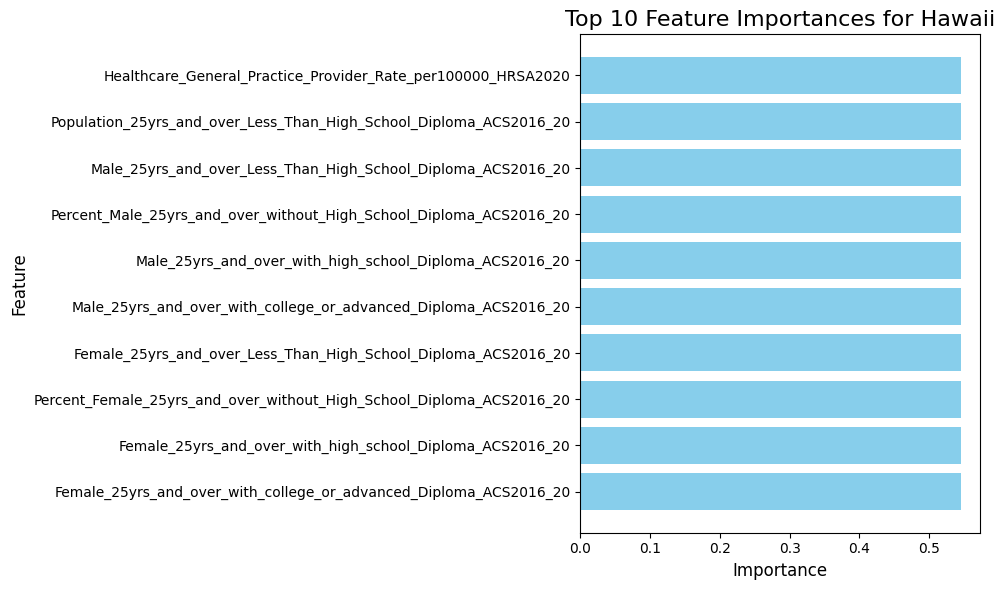

In [93]:
import matplotlib.pyplot as plt

# Select top 10 features for visualization
top_features = feature_importance.head(10)

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'], color='skyblue')

# Add labels and title
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.title("Top 10 Feature Importances for Hawaii", fontsize=16)
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top

# Display the plot
plt.tight_layout()
plt.show()


In [94]:
print(f"shap_values shape: {shap_values.shape}")
print(f"X_test shape: {X_test.shape}")


shap_values shape: (228,)
X_test shape: (1, 228)
